In [1]:
%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize
import matplotlib.dates as dates
from ipywidgets import interact, widgets
from scipy.integrate import solve_ivp
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
import copy
import sympy
%matplotlib inline
import scipy as sp
from scipy.integrate import odeint
import datetime as dt
import timeit
import time
import os
from scipy.interpolate import CubicSpline
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
np.set_printoptions(threshold=np.inf)
from prettytable import PrettyTable  
import matplotlib as mpl
import matplotlib.dates as mdates
from google.colab import files

TensorFlow 1.x selected.


In [2]:
#obtain the outputs of model from the github
beta = np.loadtxt('https://raw.githubusercontent.com/Jiel73654/CSCI7850/main/beta.csv').reshape(154,1)
gamma = np.loadtxt("https://raw.githubusercontent.com/Jiel73654/CSCI7850/main/gamma.csv").reshape(154,1)
S_learned = np.loadtxt("https://raw.githubusercontent.com/Jiel73654/CSCI7850/main/s.csv").reshape(154,1)
I_learned = np.loadtxt("https://raw.githubusercontent.com/Jiel73654/CSCI7850/main/i.csv").reshape(154,1)
R_learned = np.loadtxt("https://raw.githubusercontent.com/Jiel73654/CSCI7850/main/r.csv").reshape(154,1)

In [3]:
#get the data
data = pd.read_csv("https://raw.githubusercontent.com/Jiel73654/Qualify-Exam_JieLong/master/new-york-history.csv",error_bad_lines = False)

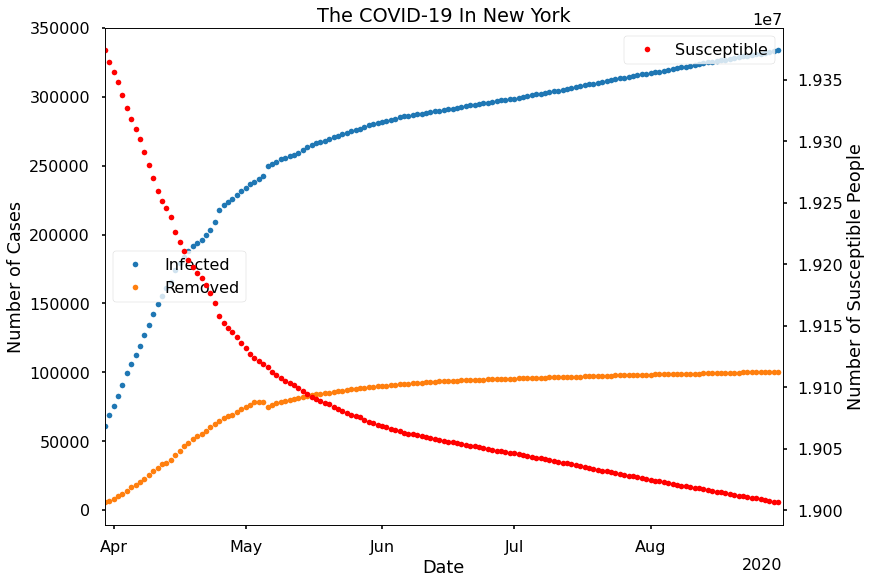

In [4]:
N0 = 19440500 #The total population of New York
length = 154 #154 days in total
a = data['recovered']
rc = a.iloc[33:(33+length)]
RC = rc.iloc[::-1].to_numpy().reshape(length,1)
dc = data['death'].iloc[33:(33+length)]
DC = dc.iloc[::-1].to_numpy().reshape(length,1)
ic = data['positive'].iloc[33:(33+length)]
IC = ic.iloc[::-1].to_numpy().reshape(length,1)
T = np.arange(0,length).reshape(length,1)
II = IC - RC - DC
SS = N0 - II - RC - DC
RR = DC + RC #removed group including deceased and recovered groups
#set the date
date_begin = dt.datetime(2020,3,30)
date_end = dt.datetime(2020,8,31)
delta = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delta)
fig, axs = plt.subplots(constrained_layout=True, figsize=(12, 8))
lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-31'))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.plot(dates, II,'.')
axs.plot(dates, RR,'.')
#axs.plot(dates, DC,'.')
axs.set_xlabel("Date")
axs.set_ylabel("Number of Cases")
axs.set_xlim(lims)
axs.legend(("Infected","Removed"),loc = "center left")
ax1 = axs.twinx()
ax1.plot(dates,SS,'.',c = 'red')
ax1.legend(["Susceptible"])
ax1.set_ylabel("Number of Susceptible People")
axs.set_title('The COVID-19 In New York')

#plt.savefig("ny_data.png")
#files.download("ny_data.png")
plt.show()

In [5]:
T = np.arange(0,length).reshape(length,1) #Time 
#build the sir function
def sir_model(z,t,beta_value,gamma):
    s = z[0,]
    i = z[1,]
    r = z[2,]
    dsdt = -beta_value*i*s
    didt = beta_value*i*s - (gamma)*i
    drdt = gamma*i
    dzdt = [dsdt,didt,drdt]
    dzdt = np.array(dzdt)
    return dzdt
t = np.arange(0,T.shape[0])
# initial condition
z10 = np.array([SS[0,0]/N0,II[0,0]/N0,RR[0,0]/N0])
rk1_s = [0.0]*T.shape[0]
rk1_i = [0.0]*T.shape[0]
rk1_r = [0.0]*T.shape[0]
#rk1_d = [0.0]*T.shape[0]
rk1_s[0] = z10[0]
rk1_i[0] = z10[1]
rk1_r[0] = z10[2]
#rk1_d[0] = z10[3]
# solve time-dependent ODE
for l in range(1,T.shape[0]):
  # span for next time step
    tspan = [t[l-1],t[l]]
    # solve for next step
    z1 = odeint(sir_model,z10,tspan,args=(beta[l-1,0],gamma[l-1,0]))
    # store solution for plotting
    rk1_s[l] = z1[1][0]
    rk1_i[l] = z1[1][1]
    rk1_r[l] = z1[1][2]
    #rk1_d[l] = z1[1][3]
    # next initial condition
    z10 = z1[1]


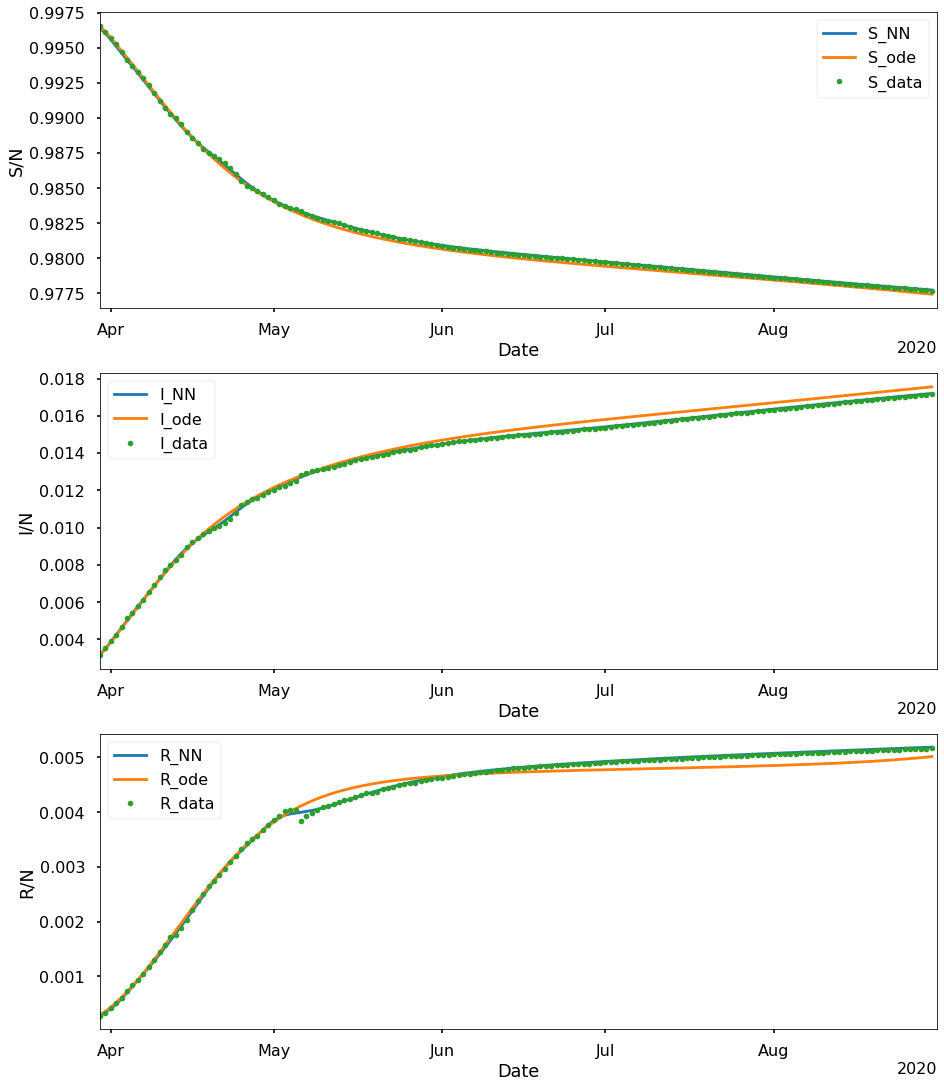

In [6]:
date_begin = dt.datetime(2020,3,30)
date_end = dt.datetime(2020,8,31)
delta = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delta)
lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-31'))
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(13, 15))
y = np.array([S_learned,I_learned,R_learned])# the estimated S,I,R by neural network
y1 = np.array([SS/N0,II/N0,RR/N0])#original data
y2 = np.array([rk1_s,rk1_i,rk1_r])#ODE results
y_label = ["S/N","I/N","R/N"]
legend = [("S_NN","S_ode","S_data"),("I_NN","I_ode","I_data"),("R_NN","R_ode","R_data")]
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, y[nn])
    ax.plot(dates, y2[nn])
    ax.plot(dates, y1[nn],'.')
    ax.set_xlabel("Date")
    ax.set_ylabel(y_label[nn])
    ax.set_xlim(lims)
    ax.legend(legend[nn])
plt.show()

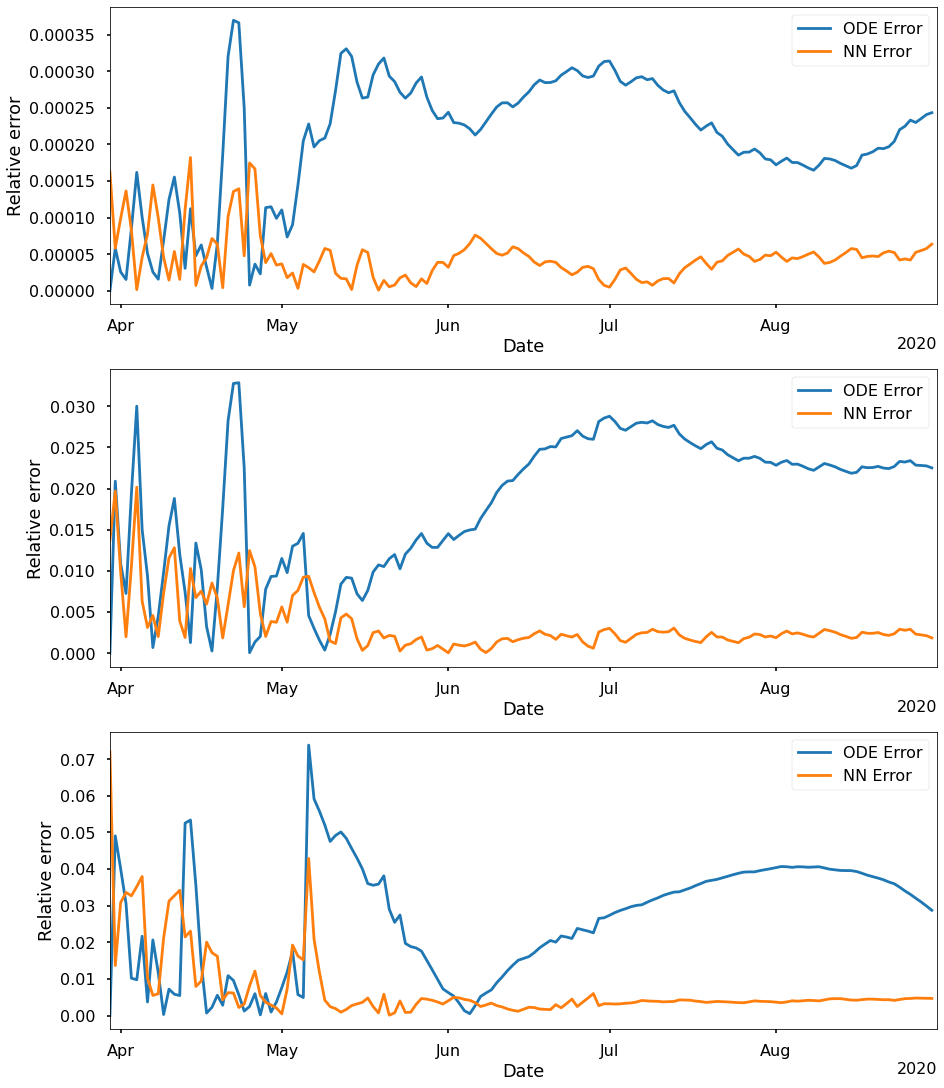

In [7]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(13, 15))
#relative errors
ode_err = np.array([np.abs(np.array(rk1_s).reshape(length,1) - SS/N0)/(SS/N0),np.abs(np.array(rk1_i).reshape(length,1) - II/N0)/(II/N0),np.abs(np.array(rk1_r).reshape(length,1) - RR/N0)/(RR/N0)])
nn_err = np.array([np.abs(S_learned - SS/N0)/(SS/N0),np.abs(I_learned - II/N0)/(II/N0),np.abs(R_learned - RR/N0)/(RR/N0)])
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, ode_err[nn])
    ax.plot(dates, nn_err[nn])
    ax.set_xlabel("Date")
    ax.set_ylabel('Relative error')
    ax.set_xlim(lims)
    ax.legend(("ODE Error","NN Error"))